# Case Study: evolution at the galapagos

In [1]:
%matplotlib inline
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#set default figsize
plt.rcParams['figure.figsize'] = [8, 6]

## Intro
Every year for the past 40-plus years, Peter and Rosemary Grant have gone to the Galápagos island of Daphne Major and collected data on Darwin's finches.
In this notebook we will analyse their data and witness evolution in action.

In [2]:
#Import the data 
df_1975 = pd.read_csv('datasets/finch_beaks_1975.csv')
df_1975['year'] = 1975
df_1975.columns = ['band','species','beak_length','beak_depth','year']
df_2012 = pd.read_csv('datasets/finch_beaks_2012.csv')
df_2012['year'] = 2012
df_2012.columns = ['band','species','beak_length','beak_depth','year']
df = pd.concat([df_1975,df_2012], ignore_index=True)
df = df[df.species == 'scandens']
df.head(5)

,band,species,beak_length,beak_depth,year
316,302,scandens,13.9,8.4,1975
317,304,scandens,14.0,8.8,1975
318,306,scandens,12.9,8.4,1975
319,310,scandens,13.5,8.0,1975
320,317,scandens,12.9,7.9,1975


## Exploratory Data Analysis - beak depths of Darwin's finches
We will study how the beak depth (the distance, top to bottom, of a closed beak) of the finch species Geospiza scandens has changed over time. The Grants have noticed some changes of beak geometry depending on the types of seeds available on the island, and they also noticed that there was some interbreeding with another major species on Daphne Major, Geospiza fortis. These effects can lead to changes in the species over time.

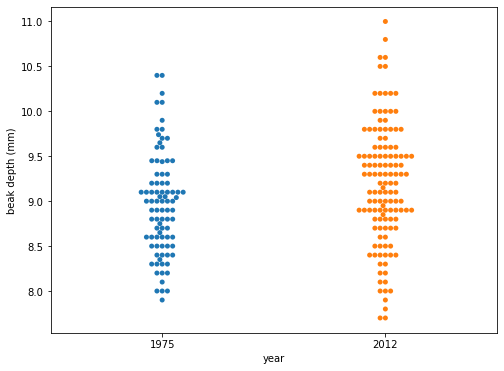

In [3]:
# Create bee swarm plot
_ = sns.swarmplot(x='year', y='beak_depth', data=df)

# Label the axes
_ = plt.xlabel('year')
_ = plt.ylabel('beak depth (mm)')

It appears as though the mean of the 2012 data set might be slightly larger, and it might have a bigger variance.

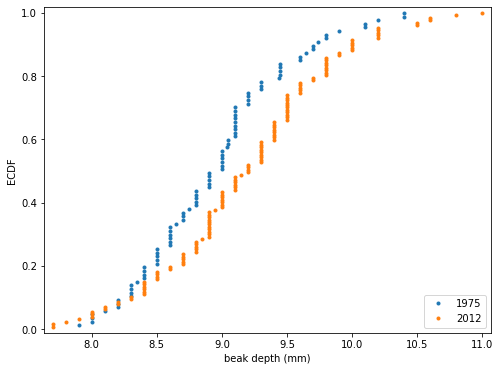

In [4]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

# Build one-dimensional array from de DataFrame
bd_1975 = df[df.year == 1975].beak_depth.to_numpy()
bd_2012 = df[df.year == 2012].beak_depth.to_numpy()


# Compute ECDFs
x_1975, y_1975 = ecdf(bd_1975)
x_2012, y_2012 = ecdf(bd_2012)

# Plot the ECDFs
_ = plt.plot(x_1975, y_1975, marker='.', linestyle='none')
_ = plt.plot(x_2012, y_2012, marker='.', linestyle='none')

# Set margins
plt.margins(0.02)

# Add axis labels and legend
_ = plt.xlabel('beak depth (mm)')
_ = plt.ylabel('ECDF')
_ = plt.legend(('1975', '2012'), loc='lower right')

The differences are much clearer in the ECDF. The mean is larger in the 2012 data, and the variance does appear larger as well.

Now, we will estimate the difference of the mean beak depth of the G. scandens samples from 1975 and 2012 and report a 95% confidence interval.


In [5]:
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data."""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

# Compute the difference of the sample means: mean_diff
mean_diff = np.mean(bd_2012) - np.mean(bd_1975)

# Get bootstrap replicates of means
bs_replicates_1975 = draw_bs_reps(bd_1975, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(bd_2012, np.mean, 10000)

# Compute samples of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975

# Compute 95% confidence interval: conf_int
conf_int = np.percentile(bs_diff_replicates, [2.5,97.5])

# Print the results
print('difference of means =', mean_diff, 'mm')
print('95% confidence interval =', conf_int, 'mm')

difference of means = 0.22622047244094645 mm
95% confidence interval = [0.06195466 0.39267479] mm


## Hypothesis test: Are beaks deeper in 2012
The plot of the ECDF and determination of the confidence interval make it pretty clear that the beaks of G. scandens on Daphne Major have gotten larger. But is it possible that this effect is just due to random chance? In other words, what is the probability that we would get the observed difference in mean beak depth if the means were the same?

In [6]:
# Compute mean of combined data set: combined_mean
combined_mean = np.mean(np.concatenate((bd_1975, bd_2012)))

# Shift the samples
bd_1975_shifted = bd_1975 - np.mean(bd_1975) + combined_mean
bd_2012_shifted = bd_2012 - np.mean(bd_2012) + combined_mean

# Get bootstrap replicates of shifted data sets
bs_replicates_1975 = draw_bs_reps(bd_1975_shifted, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(bd_2012_shifted, np.mean, 10000)

# Compute replicates of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975

# Compute the p-value
p = np.sum(bs_diff_replicates >= mean_diff) / len(bs_diff_replicates)

# Print p-value
print('p =', p)

p = 0.0044


We get a p-value of 0.0034, which suggests that there is a statistically significant difference.

## Variation in beak shapes

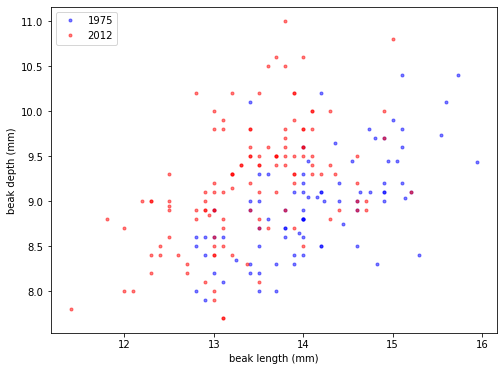

In [7]:
# Make scatter plot of 1975 data
plt.plot(df[df.year==1975].beak_length, df[df.year==1975].beak_depth, marker='.',
             linestyle='None', color='blue', alpha=0.5)

# Make scatter plot of 2012 data
plt.plot(df[df.year==2012].beak_length, df[df.year==2012].beak_depth, marker='.',
            linestyle='None', color='red', alpha=0.5)

# Label axes and make legend
plt.xlabel('beak length (mm)')
plt.ylabel('beak depth (mm)')
plt.legend(('1975', '2012'), loc='upper left')

# Show the plot
plt.show()

looking at the plot, we see that beaks got deeper (the red points are higher up in the y-direction), but not really longer. If anything, they got a bit shorter, since the red dots are to the left of the blue dots. So, it does not look like the beaks kept the same shape; they became shorter and deeper.

In [8]:
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(0,len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)

    return bs_slope_reps, bs_intercept_reps


#Variable definition
bl_1975 = df[df.year==1975].beak_length.to_numpy()
bd_1975 = df[df.year==1975].beak_depth.to_numpy()
bl_2012 = df[df.year==2012].beak_length.to_numpy()
bd_2012 = df[df.year==2012].beak_depth.to_numpy()

# Compute the linear regressions
slope_1975, intercept_1975 = np.polyfit(bl_1975, bd_1975, 1)
slope_2012, intercept_2012 = np.polyfit(bl_2012, bd_2012, 1)

# Perform pairs bootstrap for the linear regressions
bs_slope_reps_1975, bs_intercept_reps_1975 = \
        draw_bs_pairs_linreg(bl_1975, bd_1975, 1000)
bs_slope_reps_2012, bs_intercept_reps_2012 = \
        draw_bs_pairs_linreg(bl_2012, bd_2012, 1000)

# Compute confidence intervals of slopes
slope_conf_int_1975 = np.percentile(bs_slope_reps_1975, [2.5,97.5])
slope_conf_int_2012 = np.percentile(bs_slope_reps_2012, [2.5,97.5])
intercept_conf_int_1975 = np.percentile(bs_intercept_reps_1975, [2.5,97.5])

intercept_conf_int_2012 = np.percentile(bs_intercept_reps_2012, [2.5,97.5])


# Print the results
print('1975: slope =', slope_1975,
      'conf int =', slope_conf_int_1975)
print('1975: intercept =', intercept_1975,
      'conf int =', intercept_conf_int_1975)
print('2012: slope =', slope_2012,
      'conf int =', slope_conf_int_2012)
print('2012: intercept =', intercept_2012,
      'conf int =', intercept_conf_int_2012)

1975: slope = 0.46520516916059357 conf int = [0.32769086 0.58754457]
1975: intercept = 2.3908752365842285 conf int = [0.63779986 4.31023407]
2012: slope = 0.4626303588353126 conf int = [0.32767692 0.60517326]
2012: intercept = 2.9772474982360184 conf int = [1.09546041 4.79817867]


It looks like they have the same slope, but different intercepts.

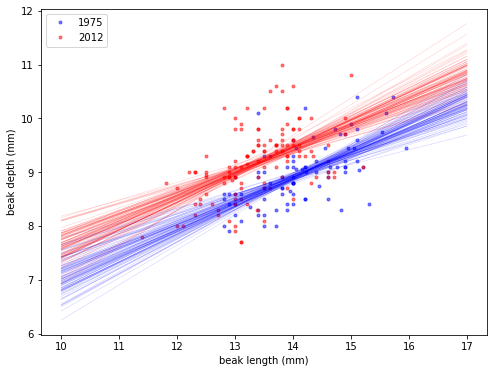

In [9]:
# Make scatter plot of 1975 data
plt.plot(bl_1975, bd_1975, marker='.',
             linestyle='none', color='blue', alpha=0.5)

# Make scatter plot of 2012 data
plt.plot(bl_2012, bd_2012, marker='.',
             linestyle='none', color='red', alpha=0.5)

# Label axes and make legend
plt.xlabel('beak length (mm)')
plt.ylabel('beak depth (mm)')
plt.legend(('1975', '2012'), loc='upper left')

# Generate x-values for bootstrap lines: x
x = np.array([10, 17])

# Plot the bootstrap lines
for i in range(100):
    plt.plot(x, x*bs_slope_reps_1975[i]+bs_intercept_reps_1975[i],
             linewidth=0.5, alpha=0.2, color='blue')
    plt.plot(x, x*bs_slope_reps_2012[i]+bs_intercept_reps_2012[i],
             linewidth=0.5, alpha=0.2, color='red')

# Draw the plot again
plt.show()

The linear regressions showed interesting information about the beak geometry. The slope was the same in 1975 and 2012, suggesting that for every millimeter gained in beak length, the birds gained about half a millimeter in depth in both years. However, if we are interested in the shape of the beak, we want to compare the ratio of beak length to beak depth.

1975: mean ratio = 1.5788823771858533 conf int = [1.55700633 1.60019688]
2012: mean ratio = 1.4658342276847767 conf int = [1.44454844 1.48766835]


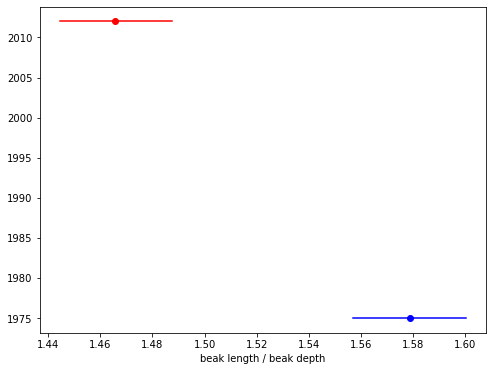

In [10]:
# Compute length-to-depth ratios
ratio_1975 = bl_1975 / bd_1975
ratio_2012 = bl_2012 / bd_2012

# Compute means
mean_ratio_1975 = np.mean(ratio_1975)
mean_ratio_2012 = np.mean(ratio_2012)

# Generate bootstrap replicates of the means
bs_replicates_1975 = draw_bs_reps(ratio_1975, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(ratio_2012, np.mean, 10000)

# Compute the 99% confidence intervals
conf_int_1975 = np.percentile(bs_replicates_1975, [0.5,99.5])
conf_int_2012 = np.percentile(bs_replicates_2012, [0.5,99.5])

# Print the results
print('1975: mean ratio =', mean_ratio_1975,
      'conf int =', conf_int_1975)
print('2012: mean ratio =', mean_ratio_2012,
      'conf int =', conf_int_2012)

#Plot the results
plt.plot(conf_int_1975, [1975,1975], color = 'blue')
plt.plot(mean_ratio_1975, 1975, marker='o', color = 'blue')
plt.plot(conf_int_2012, [2012,2012], color = 'red')
plt.plot(mean_ratio_2012, 2012, marker='o', color = 'red')
plt.xlabel('beak length / beak depth')
plt.show()

The mean beak length-to-depth ratio decreased by about 0.1, or 7%, from 1975 to 2012. The 99% confidence intervals are not even close to overlapping, so this is a real change. The beak shape changed.

## EDA of heritability

In [11]:
bd_parent_scandens = np.array([8.3318,  8.4035,  8.5317,  8.7202,  8.7089,  8.7541,  8.773 ,
        8.8107,  8.7919,  8.8069,  8.6523,  8.6146,  8.6938,  8.7127,
        8.7466,  8.7504,  8.7805,  8.7428,  8.7164,  8.8032,  8.8258,
        8.856 ,  8.9012,  8.9125,  8.8635,  8.8258,  8.8522,  8.8974,
        8.9427,  8.9879,  8.9615,  8.9238,  8.9351,  9.0143,  9.0558,
        9.0596,  8.9917,  8.905 ,  8.9314,  8.9465,  8.9879,  8.9804,
        9.0219,  9.052 ,  9.0407,  9.0407,  8.9955,  8.9992,  8.9992,
        9.0747,  9.0747,  9.5385,  9.4781,  9.4517,  9.3537,  9.2707,
        9.1199,  9.1689,  9.1425,  9.135 ,  9.1011,  9.1727,  9.2217,
        9.2255,  9.2821,  9.3235,  9.3198,  9.3198,  9.3198,  9.3273,
        9.3725,  9.3989,  9.4253,  9.4593,  9.4442,  9.4291,  9.2632,
        9.2293,  9.1878,  9.1425,  9.1275,  9.1802,  9.1765,  9.2481,
        9.2481,  9.1991,  9.1689,  9.1765,  9.2406,  9.3198,  9.3235,
        9.1991,  9.2971,  9.2443,  9.316 ,  9.2934,  9.3914,  9.3989,
        9.5121,  9.6176,  9.5535,  9.4668,  9.3725,  9.3348,  9.3763,
        9.3839,  9.4216,  9.4065,  9.3348,  9.4442,  9.4367,  9.5083,
        9.448 ,  9.4781,  9.595 ,  9.6101,  9.5686,  9.6365,  9.7119,
        9.8213,  9.825 ,  9.7609,  9.6516,  9.5988,  9.546 ,  9.6516,
        9.7572,  9.8854, 10.0023,  9.3914])
bd_offspring_scandens = np.array([ 8.419 ,  9.2468,  8.1532,  8.0089,  8.2215,  8.3734,  8.5025,
        8.6392,  8.7684,  8.8139,  8.7911,  8.9051,  8.9203,  8.8747,
        8.943 ,  9.0038,  8.981 ,  9.0949,  9.2696,  9.1633,  9.1785,
        9.1937,  9.2772,  9.0722,  8.9658,  8.9658,  8.5025,  8.4949,
        8.4949,  8.5633,  8.6013,  8.6468,  8.1532,  8.3734,  8.662 ,
        8.6924,  8.7456,  8.8367,  8.8595,  8.9658,  8.9582,  8.8671,
        8.8671,  8.943 ,  9.0646,  9.1405,  9.2089,  9.2848,  9.3759,
        9.4899,  9.4519,  8.1228,  8.2595,  8.3127,  8.4949,  8.6013,
        8.4646,  8.5329,  8.7532,  8.8823,  9.0342,  8.6392,  8.6772,
        8.6316,  8.7532,  8.8291,  8.8975,  8.9734,  9.0494,  9.1253,
        9.1253,  9.1253,  9.1785,  9.2848,  9.4595,  9.3608,  9.2089,
        9.2544,  9.3684,  9.3684,  9.2316,  9.1709,  9.2316,  9.0342,
        8.8899,  8.8291,  8.981 ,  8.8975, 10.4089, 10.1886,  9.7633,
        9.7329,  9.6114,  9.5051,  9.5127,  9.3684,  9.6266,  9.5354,
       10.0215, 10.0215,  9.6266,  9.6038,  9.4063,  9.2316,  9.338 ,
        9.262 ,  9.262 ,  9.4063,  9.4367,  9.0342,  8.943 ,  8.9203,
        8.7835,  8.7835,  9.057 ,  8.9354,  8.8975,  8.8139,  8.8671,
        9.0873,  9.2848,  9.2392,  9.2924,  9.4063,  9.3152,  9.4899,
        9.5962,  9.6873,  9.5203,  9.6646])
bd_parent_fortis = np.array([10.1  ,  9.55 ,  9.4  , 10.25 , 10.125,  9.7  ,  9.05 ,  7.4  ,
        9.   ,  8.65 ,  9.625,  9.9  ,  9.55 ,  9.05 ,  8.35 , 10.1  ,
       10.1  ,  9.9  , 10.225, 10.   , 10.55 , 10.45 ,  9.2  , 10.2  ,
        8.95 , 10.05 , 10.2  ,  9.5  ,  9.925,  9.95 , 10.05 ,  8.75 ,
        9.2  , 10.15 ,  9.8  , 10.7  , 10.5  ,  9.55 , 10.55 , 10.475,
        8.65 , 10.7  ,  9.1  ,  9.4  , 10.3  ,  9.65 ,  9.5  ,  9.7  ,
       10.525,  9.95 , 10.1  ,  9.75 , 10.05 ,  9.9  , 10.   ,  9.1  ,
        9.45 ,  9.25 ,  9.5  , 10.   , 10.525,  9.9  , 10.4  ,  8.95 ,
        9.4  , 10.95 , 10.75 , 10.1  ,  8.05 ,  9.1  ,  9.55 ,  9.05 ,
       10.2  , 10.   , 10.55 , 10.75 ,  8.175,  9.7  ,  8.8  , 10.75 ,
        9.3  ,  9.7  ,  9.6  ,  9.75 ,  9.6  , 10.45 , 11.   , 10.85 ,
       10.15 , 10.35 , 10.4  ,  9.95 ,  9.1  , 10.1  ,  9.85 ,  9.625,
        9.475,  9.   ,  9.25 ,  9.1  ,  9.25 ,  9.2  ,  9.95 ,  8.65 ,
        9.8  ,  9.4  ,  9.   ,  8.55 ,  8.75 ,  9.65 ,  8.95 ,  9.15 ,
        9.85 , 10.225,  9.825, 10.   ,  9.425, 10.4  ,  9.875,  8.95 ,
        8.9  ,  9.35 , 10.425, 10.   , 10.175,  9.875,  9.875,  9.15 ,
        9.45 ,  9.025,  9.7  ,  9.7  , 10.05 , 10.3  ,  9.6  , 10.   ,
        9.8  , 10.05 ,  8.75 , 10.55 ,  9.7  , 10.   ,  9.85 ,  9.8  ,
        9.175,  9.65 ,  9.55 ,  9.9  , 11.55 , 11.3  , 10.4  , 10.8  ,
        9.8  , 10.45 , 10.   , 10.75 ,  9.35 , 10.75 ,  9.175,  9.65 ,
        8.8  , 10.55 , 10.675,  9.95 ,  9.55 ,  8.825,  9.7  ,  9.85 ,
        9.8  ,  9.55 ,  9.275, 10.325,  9.15 ,  9.35 ,  9.15 ,  9.65 ,
       10.575,  9.975,  9.55 ,  9.2  ,  9.925,  9.2  ,  9.3  ,  8.775,
        9.325,  9.175,  9.325,  8.975,  9.7  ,  9.5  , 10.225, 10.025,
        8.2  ,  8.2  ,  9.55 ,  9.05 ,  9.6  ,  9.6  , 10.15 ,  9.875,
       10.485, 11.485, 10.985,  9.7  ,  9.65 ,  9.35 , 10.05 , 10.1  ,
        9.9  ,  8.95 ,  9.3  ,  9.95 ,  9.45 ,  9.5  ,  8.45 ,  8.8  ,
        8.525,  9.375, 10.2  ,  7.625,  8.375,  9.25 ,  9.4  , 10.55 ,
        8.9  ,  8.8  ,  9.   ,  8.575,  8.575,  9.6  ,  9.375,  9.6  ,
        9.95 ,  9.6  , 10.2  ,  9.85 ,  9.625,  9.025, 10.375, 10.25 ,
        9.3  ,  9.5  ,  9.55 ,  8.55 ,  9.05 ,  9.9  ,  9.8  ,  9.75 ,
       10.25 ,  9.1  ,  9.65 , 10.3  ,  8.9  ,  9.95 ,  9.5  ,  9.775,
        9.425,  7.75 ,  7.55 ,  9.1  ,  9.6  ,  9.575,  8.95 ,  9.65 ,
        9.65 ,  9.65 ,  9.525,  9.85 ,  9.05 ,  9.3  ,  8.9  ,  9.45 ,
       10.   ,  9.85 ,  9.25 , 10.1  ,  9.125,  9.65 ,  9.1  ,  8.05 ,
        7.4  ,  8.85 ,  9.075,  9.   ,  9.7  ,  8.7  ,  9.45 ,  9.7  ,
        8.35 ,  8.85 ,  9.7  ,  9.45 , 10.3  , 10.   , 10.45 ,  9.45 ,
        8.5  ,  8.3  , 10.   ,  9.225,  9.75 ,  9.15 ,  9.55 ,  9.   ,
        9.275,  9.35 ,  8.95 ,  9.875,  8.45 ,  8.6  ,  9.7  ,  8.55 ,
        9.05 ,  9.6  ,  8.65 ,  9.2  ,  8.95 ,  9.6  ,  9.15 ,  9.4  ,
        8.95 ,  9.95 , 10.55 ,  9.7  ,  8.85 ,  8.8  , 10.   ,  9.05 ,
        8.2  ,  8.1  ,  7.25 ,  8.3  ,  9.15 ,  8.6  ,  9.5  ,  8.05 ,
        9.425,  9.3  ,  9.8  ,  9.3  ,  9.85 ,  9.5  ,  8.65 ,  9.825,
        9.   , 10.45 ,  9.1  ,  9.55 ,  9.05 , 10.   ,  9.35 ,  8.375,
        8.3  ,  8.8  , 10.1  ,  9.5  ,  9.75 , 10.1  ,  9.575,  9.425,
        9.65 ,  8.725,  9.025,  8.5  ,  8.95 ,  9.3  ,  8.85 ,  8.95 ,
        9.8  ,  9.5  ,  8.65 ,  9.1  ,  9.4  ,  8.475,  9.35 ,  7.95 ,
        9.35 ,  8.575,  9.05 ,  8.175,  9.85 ,  7.85 ,  9.85 , 10.1  ,
        9.35 ,  8.85 ,  8.75 ,  9.625,  9.25 ,  9.55 , 10.325,  8.55 ,
        9.675,  9.15 ,  9.   ,  9.65 ,  8.6  ,  8.8  ,  9.   ,  9.95 ,
        8.4  ,  9.35 , 10.3  ,  9.05 ,  9.975,  9.975,  8.65 ,  8.725,
        8.2  ,  7.85 ,  8.775,  8.5  ,  9.4  ])
bd_offspring_fortis = np.array([10.7 ,  9.78,  9.48,  9.6 , 10.27,  9.5 ,  9.  ,  7.46,  7.65,
        8.63,  9.81,  9.4 ,  9.48,  8.75,  7.6 , 10.  , 10.09,  9.74,
        9.64,  8.49, 10.15, 10.28,  9.2 , 10.01,  9.03,  9.94, 10.5 ,
        9.7 , 10.02, 10.04,  9.43,  8.1 ,  9.5 ,  9.9 ,  9.48, 10.18,
       10.16,  9.08, 10.39,  9.9 ,  8.4 , 10.6 ,  8.75,  9.46,  9.6 ,
        9.6 ,  9.95, 10.05, 10.16, 10.1 ,  9.83,  9.46,  9.7 ,  9.82,
       10.34,  8.02,  9.65,  9.87,  9.  , 11.14,  9.25,  8.14, 10.23,
        8.7 ,  9.8 , 10.54, 11.19,  9.85,  8.1 ,  9.3 ,  9.34,  9.19,
        9.52,  9.36,  8.8 ,  8.6 ,  8.  ,  8.5 ,  8.3 , 10.38,  8.54,
        8.94, 10.  ,  9.76,  9.45,  9.89, 10.9 ,  9.91,  9.39,  9.86,
        9.74,  9.9 ,  9.09,  9.69, 10.24,  8.9 ,  9.67,  8.93,  9.3 ,
        8.67,  9.15,  9.23,  9.59,  9.03,  9.58,  8.97,  8.57,  8.47,
        8.71,  9.21,  9.13,  8.5 ,  9.58,  9.21,  9.6 ,  9.32,  8.7 ,
       10.46,  9.29,  9.24,  9.45,  9.35, 10.19,  9.91,  9.18,  9.89,
        9.6 , 10.3 ,  9.45,  8.79,  9.2 ,  8.8 ,  9.69, 10.61,  9.6 ,
        9.9 ,  9.26, 10.2 ,  8.79,  9.28,  8.83,  9.76, 10.2 ,  9.43,
        9.4 ,  9.9 ,  9.5 ,  8.95,  9.98,  9.72,  9.86, 11.1 ,  9.14,
       10.49,  9.75, 10.35,  9.73,  9.83,  8.69,  9.58,  8.42,  9.25,
       10.12,  9.31,  9.99,  8.59,  8.74,  8.79,  9.6 ,  9.52,  8.93,
       10.23,  9.35,  9.35,  9.09,  9.04,  9.75, 10.5 ,  9.09,  9.05,
        9.54,  9.3 ,  9.06,  8.7 ,  9.32,  8.4 ,  8.67,  8.6 ,  9.53,
        9.77,  9.65,  9.43,  8.35,  8.26,  9.5 ,  8.6 ,  9.57,  9.14,
       10.79,  8.91,  9.93, 10.7 ,  9.3 ,  9.93,  9.51,  9.44, 10.05,
       10.13,  9.24,  8.21,  8.9 ,  9.34,  8.77,  9.4 ,  8.82,  8.83,
        8.6 ,  9.5 , 10.2 ,  8.09,  9.07,  9.29,  9.1 , 10.19,  9.25,
        8.98,  9.02,  8.6 ,  8.25,  8.7 ,  9.9 ,  9.65,  9.45,  9.38,
       10.4 ,  9.96,  9.46,  8.26, 10.05,  8.92,  9.5 ,  9.43,  8.97,
        8.44,  8.92, 10.3 ,  8.4 ,  9.37,  9.91, 10.  ,  9.21,  9.95,
        8.84,  9.82,  9.5 , 10.29,  8.4 ,  8.31,  9.29,  8.86,  9.4 ,
        9.62,  8.62,  8.3 ,  9.8 ,  8.48,  9.61,  9.5 ,  9.37,  8.74,
        9.31,  9.5 ,  9.49,  9.74,  9.2 ,  9.24,  9.7 ,  9.64,  9.2 ,
        7.5 ,  7.5 ,  8.7 ,  8.31,  9.  ,  9.74,  9.31, 10.5 ,  9.3 ,
        8.12,  9.34,  9.72,  9.  ,  9.65,  9.9 , 10.  , 10.1 ,  8.  ,
        9.07,  9.75,  9.33,  8.11,  9.36,  9.74,  9.9 ,  9.23,  9.7 ,
        8.2 ,  9.35,  9.49,  9.34,  8.87,  9.03,  9.07,  9.43,  8.2 ,
        9.19,  9.  ,  9.2 ,  9.06,  9.81,  8.89,  9.4 , 10.45,  9.64,
        9.03,  8.71,  9.91,  8.33,  8.2 ,  7.83,  7.14,  8.91,  9.18,
        8.8 ,  9.9 ,  7.73,  9.25,  8.7 ,  9.5 ,  9.3 ,  9.05, 10.18,
        8.85,  9.24,  9.15,  9.98,  8.77,  9.8 ,  8.65, 10.  ,  8.81,
        8.01,  7.9 ,  9.41, 10.18,  9.55,  9.08,  8.4 ,  9.75,  8.9 ,
        9.07,  9.35,  8.9 ,  8.19,  8.65,  9.19,  8.9 ,  9.28, 10.58,
        9.  ,  9.4 ,  8.91,  9.93, 10.  ,  9.37,  7.4 ,  9.  ,  8.8 ,
        9.18,  8.3 , 10.08,  7.9 ,  9.96, 10.4 ,  9.65,  8.8 ,  8.65,
        9.7 ,  9.23,  9.43,  9.93,  8.47,  9.55,  9.28,  8.85,  8.9 ,
        8.75,  8.63,  9.  ,  9.43,  8.28,  9.23, 10.4 ,  9.  ,  9.8 ,
        9.77,  8.97,  8.37,  7.7 ,  7.9 ,  9.5 ,  8.2 ,  8.8 ])

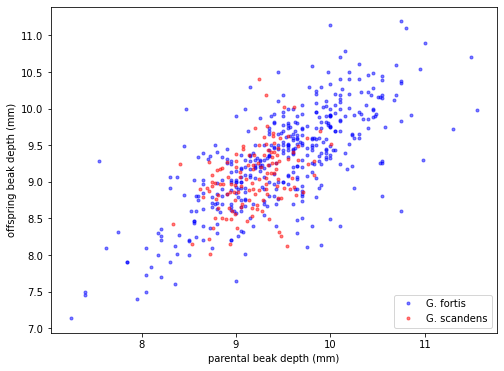

In [12]:
# Make scatter plots
_ = plt.plot(bd_parent_fortis, bd_offspring_fortis,
             marker='.', linestyle='none', color='blue', alpha=0.5)
_ = plt.plot(bd_parent_scandens, bd_offspring_scandens,
             marker='.', linestyle='none', color='red', alpha=0.5)

# Label axes
_ = plt.xlabel('parental beak depth (mm)')
_ = plt.ylabel('offspring beak depth (mm)')

# Add legend
_ = plt.legend(('G. fortis', 'G. scandens'), loc='lower right')

# Show plot
plt.show()


It appears as though there is a stronger correlation in G. fortis than in G. scandens. This suggests that beak depth is more strongly inherited in G. fortis. We'll quantify this correlation next.

## Correlation of offspring and parental data

In an effort to quantify the correlation between offspring and parent beak depths, we would like to compute statistics, such as the Pearson correlation coefficient, between parents and offspring. To get confidence intervals on this, we need to do a pairs bootstrap.

In [14]:
def draw_bs_pairs(x, y, func, size=1):
    """Perform pairs bootstrap for a single statistic."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_replicates[i] = func(bs_x, bs_y)

    return bs_replicates

def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef(x, y)

    # Return entry [0,1]
    return corr_mat[0,1]

# Compute the Pearson correlation coefficients
r_scandens = pearson_r(bd_parent_scandens, bd_offspring_scandens)
r_fortis = pearson_r(bd_parent_fortis, bd_offspring_fortis)

# Acquire 1000 bootstrap replicates of Pearson r
bs_replicates_scandens = draw_bs_pairs(bd_parent_scandens, bd_offspring_scandens, pearson_r, 1000)

bs_replicates_fortis = draw_bs_pairs(bd_parent_fortis, bd_offspring_fortis, pearson_r, 1000)


# Compute 95% confidence intervals
conf_int_scandens = np.percentile(bs_replicates_scandens, [2.5,97.5])
conf_int_fortis = np.percentile(bs_replicates_fortis, [2.5, 97.5])

# Print results
print('G. scandens:', r_scandens, conf_int_scandens)
print('G. fortis:', r_fortis, conf_int_fortis)

G. scandens: 0.4117063629401259 [0.26435154 0.54406244]
G. fortis: 0.7283412395518485 [0.6706123  0.78160634]


It is clear from the confidence intervals that beak depth of the offspring of G. fortis parents is more strongly correlated with their offspring than their G. scandens counterparts.

In [ ]:
def heritability(parents, offspring):
    """Compute the heritability from parent and offspring samples."""
    covariance_matrix = np.cov(parents, offspring)
    return covariance_matrix[0][1] / covariance_matrix[0][0]

# Compute the heritability
heritability_scandens = heritability(bd_parent_scandens, bd_offspring_scandens)
heritability_fortis = heritability(bd_parent_fortis, bd_offspring_fortis)

# Acquire 1000 bootstrap replicates of heritability
replicates_scandens = draw_bs_pairs(
        bd_parent_scandens, bd_offspring_scandens, heritability, size=1000)
        
replicates_fortis = draw_bs_pairs(
        bd_parent_fortis, bd_offspring_fortis, heritability, size=1000)


# Compute 95% confidence intervals
conf_int_scandens = np.percentile(replicates_scandens, [2.5,97.5])
conf_int_fortis = np.percentile(replicates_fortis,[2.5,97.5])

# Print results
print('G. scandens:', heritability_scandens, conf_int_scandens)
print('G. fortis:', heritability_fortis, conf_int_fortis)